In [1]:
import wikipedia
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForMaskedLM
import tensorflow as tf
from datasets import Dataset
import datasets
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN

import numpy as np
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors
from pypdf import PdfReader
import os
import tensorflow as tf
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [2]:

directory_path = '/Users/ammar/Developer/loose/testembedclustering/documents/'
document = ""

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        reader = PdfReader(directory_path + filename) 
        for i in range(len(reader.pages)):
            page = reader.pages[i].extract_text()
            page = page.replace("\n", " ")
            document += page


In [3]:
document = ""


In [4]:
document += wikipedia.page("History of the United States").content

In [5]:
document += wikipedia.page("History of Europe").content

In [6]:
document += wikipedia.page("History of China").content

In [7]:
document += wikipedia.page("History of Poland").content

In [8]:
document += wikipedia.page("History of philosophy").content

In [9]:
document += wikipedia.page("History of Germany").content

In [10]:
document += wikipedia.page("History of Christianity").content

In [11]:
document += wikipedia.page("History of Wikipedia").content

In [12]:
document += wikipedia.page("History of Australia").content
document += wikipedia.page("History of television").content
document += wikipedia.page("History of Spain").content
document += wikipedia.page("History of Rome").content
document += wikipedia.page("History of Italy").content
document += wikipedia.page("History of Korea").content
document += wikipedia.page("History of medicine").content
document += wikipedia.page("History of art").content
document += wikipedia.page("History of Afghanistan").content
document += wikipedia.page("History of gunpowder").content
document += wikipedia.page("History of Palestine").content


In [13]:
len(document)

2076920

In [14]:
chunks = document.split('.')
print(len(chunks))



16054


In [15]:
df = pd.DataFrame(chunks, columns=['Chunks'])

In [16]:
display(df)

Chunks
0      The history of the lands that became the Unite...
1       Numerous indigenous cultures formed, and thei...
2       Starting in 1585, the British Empire colonize...
3      \nThe Southern Colonies built an agricultural ...
4       After defeating France, the British Parliamen...
...                                                  ...
16049      Archived from the original on 19 January 2023
16050                         Retrieved 23 December 2020
16051  \n\n\n== External links ==\nPicturesque Palest...
16052   (published 1881–1884) image gallery at New Yo...
16053                    \nSyria and Palestine from 1920

[16054 rows x 1 columns]

In [17]:
dataset = Dataset.from_pandas(df)


In [18]:
dataset

Dataset({
    features: ['Chunks'],
    num_rows: 16054
})

In [19]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU via Metal")
else:
    print("Using CPU")


Using GPU via Metal


In [20]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = TFAutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

2024-06-29 20:33:40.415757: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-29 20:33:40.415782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-29 20:33:40.415787: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-29 20:33:40.416307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-29 20:33:40.416337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the

In [21]:
def embed(texts):
    inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[-1]

    return embeddings

def embed_batch(batch):
    embeddings = embed(batch["Chunks"])
    batch_size = tf.shape(embeddings)[0]
    return {"embed": [embeddings[i] for i in range(batch_size)]}



In [22]:
embedded_dataset = dataset.map(embed_batch, batched=True, batch_size=16)  # Adjust batch_size as needed

/Users/ammar/Developer/miniforge3/envs/coursera/lib/python3.8/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/16054 [00:00<?, ? examples/s]

In [19]:
def embed2(text):
    inputs = tokenizer(text, return_tensors='tf')
    outputs = model(inputs, output_hidden_states=True)
    tokens = inputs["input_ids"][0]
    embeddings = outputs.hidden_states[-1][0]
    print(tokens.shape, embeddings.shape)
    return {'embed':embeddings}



In [ ]:
embedded_dataset2 = dataset.map(lambda examples: embed2(examples["Chunks"]))

In [23]:
def average_embeddings(examples):
    examples['averaged_embeddings'] = [np.mean(embedding, axis=0) for embedding in examples['embed']]
    return examples

embedded_dataset = embedded_dataset.map(average_embeddings, batched=True)


Map:   0%|          | 0/16054 [00:00<?, ? examples/s]

In [24]:
embedded_dataset.save_to_disk("embedded_dataset")

Saving the dataset (0/6 shards):   0%|          | 0/16054 [00:00<?, ? examples/s]

In [25]:
embedded_dataset = datasets.load_from_disk("embedded_dataset")

In [26]:
embedded_dataset

Dataset({
    features: ['Chunks', 'embed', 'averaged_embeddings'],
    num_rows: 16054
})

In [27]:
averaged_embeddings = np.array(embedded_dataset['averaged_embeddings'])


In [28]:
averaged_embeddings.shape

(16054, 768)

In [29]:
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(averaged_embeddings)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
reduced_embeddings.shape

(16054, 2)

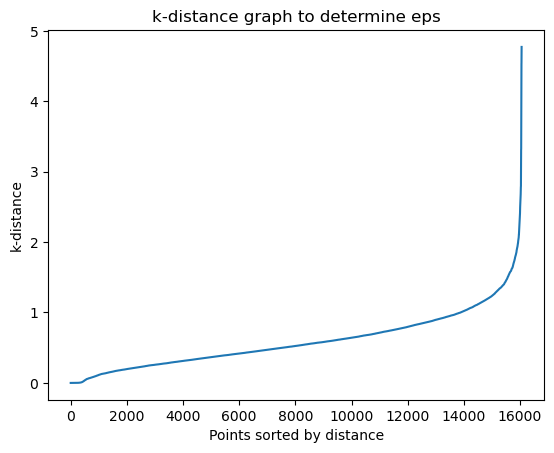

Optimal eps value: 1.7178321979460291


In [53]:
k = 3
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(reduced_embeddings)
distances, indices = nbrs.kneighbors(reduced_embeddings)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-distance graph to determine eps')
plt.show()

kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')
optimal_eps = distances[kneedle.elbow]

print(f'Optimal eps value: {optimal_eps}')

In [54]:
db = DBSCAN(eps=optimal_eps, min_samples=k).fit(reduced_embeddings)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



Estimated number of clusters: 217
Estimated number of noise points: 209


In [56]:
db = HDBSCAN().fit(reduced_embeddings)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)



Estimated number of clusters: 932
Estimated number of noise points: 4655


## 2d

In [81]:
clustered_dataset = embedded_dataset.add_column('cluster', labels)

scale_factor = 1
scaled_embeddings = reduced_embeddings * scale_factor

tsne_df = pd.DataFrame(scaled_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']

fig = px.scatter_matrix(
    tsne_df,
    dimensions=['Component 1', 'Component 2'],
    color='cluster',
    hover_data=['text'],
    title="Scatter Plot Matrix of Clusters"
)

fig.update_traces(marker=dict(size=6))  # Adjust size as needed


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[tsne_df['Component 1'].min()-10, tsne_df['Component 1'].max()+10]),
        yaxis=dict(nticks=10, range=[tsne_df['Component 2'].min()-10, tsne_df['Component 2'].max()+10]),
        aspectratio=dict(x=1.5, y=1.5)
    )
)

fig.show()

In [82]:
clustered_dataset = embedded_dataset.add_column('cluster', labels)
clustered_dataset

scale_factor = 1

scaled_embeddings = reduced_embeddings * scale_factor

tsne_df = pd.DataFrame(scaled_embeddings, columns=['Component 1', 'Component 2'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']


fig = px.scatter(
    tsne_df,
    x='Component 1',
    y='Component 2',
    color='cluster',
    hover_data=['text'],
    #color_continuous_scale=px.colors.diverging.BrBG
)

fig.update_traces(marker=dict(size=6))  # Adjust size as needed


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[tsne_df['Component 1'].min()-10, tsne_df['Component 1'].max()+10]),
        yaxis=dict(nticks=10, range=[tsne_df['Component 2'].min()-10, tsne_df['Component 2'].max()+10]),
        aspectratio=dict(x=1.5, y=1.5)
    )
)

fig.show()

## 3d


In [24]:
clustered_dataset = embedded_dataset.add_column('cluster', labels)
clustered_dataset

scale_factor = 1

scaled_embeddings = reduced_embeddings * scale_factor

tsne_df = pd.DataFrame(scaled_embeddings, columns=['Component 1', 'Component 2', 'Component 3'])
tsne_df['text'] = clustered_dataset['Chunks']
tsne_df['cluster'] = clustered_dataset['cluster']


fig = px.scatter_3d(
    tsne_df,
    x='Component 1',
    y='Component 2',
    z='Component 3',
    color='cluster',
    hover_data=['text'],
    #color_continuous_scale=px.colors.diverging.BrBG
)

fig.update_traces(marker=dict(size=3.5))  # Adjust size as needed


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[tsne_df['Component 1'].min()-10, tsne_df['Component 1'].max()+10]),
        yaxis=dict(nticks=10, range=[tsne_df['Component 2'].min()-10, tsne_df['Component 2'].max()+10]),
        zaxis=dict(nticks=10, range=[tsne_df['Component 3'].min()-10, tsne_df['Component 3'].max()+10]),
        aspectratio=dict(x=1.5, y=1.5, z=1.5)
    )
)

fig.show()

In [74]:
fig.write_html("interactive_plot4.html")
    